# Packages necessary


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
from scipy.interpolate import interp1d
from datetime import timedelta
from scipy.stats import gmean
from scipy.optimize import minimize
from datetime import datetime
from statistics import mean
# Importations nécessaires
from scipy.stats import norm,chi2
import ipywidgets as widgets
from IPython.display import display
import warnings
from scipy.stats import chi2, binom

warnings.filterwarnings("ignore")

In [ ]:
# import os
# os._exit(00)


Definissons les tests pour le Backtesting

In [ ]:
def test_var(pnl, var, alpha):
    # Calcul des bornes vertes et jaunes
    Borne_Green = stats.binom.ppf(0.950, len(pnl), alpha) #0.01
    Borne_Yellow = stats.binom.ppf(0.999, len(pnl), alpha)
    
    # Calcul du nombre total de violations
    violations = (pnl < var).sum() # combien des P&L qui sont inferieur de -VaR=var(je considere la VaR est positive)
    
    # Déterminer la zone de la proportion d'exceptions
    if violations <= Borne_Green:
        zone = 'Verte --- Satisfaisante par rapport au niveau de confiance'
    elif violations <= Borne_Yellow:
        zone = 'Jaune --- Légèrement élevée pour le niveau de confiance'
    else:
        zone = 'Rouge --- Très élevée pour le niveau de confiance'
    
    return zone 

## Test de Vraisemblance
def test_hypothesis_and_compute_statistic(PnLs, Var, alpha, significance_level = 0.95):
    N = len(PnLs)
    X = (PnLs > Var).sum()

    q =  1 - alpha #alpha = 95% 
    dof  = 1 

    # Calcul de la première partie de la formule
    part1 = (N - X) / (q * (N))
    
    # Calcul de la deuxième partie de la formule
    part2 = X / ((1 - q) * (N))
    
    # Logarithme de la première partie élevée à la puissance (N - X)
    log_part1 = (N - X) * np.log(part1)
    
    # Logarithme de la deuxième partie élevée à la puissance X
    log_part2 = X * np.log(part2)
    
    # Somme des logarithmes
    log_sum = log_part1 + log_part2
    
    # Multiplier par 2 pour obtenir -2log(Λ)
    statistic = 2 * log_sum
    
    # Le p value
    pvalue = 1 - stats.chi2.cdf(statistic, dof)
    
    # Quantile critique pour la distribution chi-carré avec 'dof' degrés de liberté
    critical_value = chi2.ppf(significance_level, dof)
    
    # Test de l'hypothèse
    if statistic > critical_value:
        result = "Reject H0: q*(Pr[It(alpha) = 1] = E[It(alpha)] = alpha=.99) != q"
    else:
        result = "Accept H0: q*(Pr[It(alpha) = 1] = E[It(alpha)] = alpha=0.99) = q"
    
    return pvalue,statistic, result


# Notes sur le modèle CIR

- Nous remarquons que cela est très similaire au modèle de Vasicek, avec l'ajout unique du terme $\sqrt(r_t)$.
- Ce terme tendra vers zéro lorsque le taux court approche de zéro, éliminant efficacement la volatilité lorsque le taux court diminue.
- L'ajout de ce terme forcera $r_t$ à rester non négatif dans le modèle CIR, contrairement au modèle de Vasicek.
- Cependant, un inconvénient majeur est que l'ajout du terme limitant la volatilité rend le modèle CIR, contrairement au modèle de Vasicek, non gaussien.(En d'autres termes, les variations du taux d'intérêt ne suivent plus une distribution gaussienne, mais une autre distribution plus complexe.)


In [ ]:
# Chargement des données depuis le fichier Excel
data_BDT = pd.read_excel(r'C:\Users\hp\Desktop\Global folder for PFE\trainig intership\Calculation_VaR\data\BDT.xlsx')
data_BDT.describe()

In [ ]:
data_zc=pd.read_excel(r'C:\Users\hp\Desktop\Global folder for PFE\trainig intership\Calculation_VaR\data\data_zc.xlsx')
df=data_zc.copy()

In [167]:
df.to_csv("df.csv")

In [ ]:
maturities = np.array(
    [ 1/365.25  , 7/365.25, 1/12, 2/12 , 3/12, 6/12, 9/12, 1 , 2 , 3 , 4 , 5 , 6 , 
  7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
  19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30]
)

In [ ]:
# Calcul Taux zc CIR---------------------------------------------------------------------
def A(x, a, b, sigma):                                                                  #
    gamma = np.sqrt(a**2 + 2 * sigma**2)
    numerator = 2 * gamma * np.exp((a + gamma) * (x) / 2)
    denominator = (a + gamma) * (np.exp(gamma * (x)) - 1) + 2 * gamma                       
    return (numerator / denominator) ** (2 * a * b / sigma**2)
def B(x, a, sigma):
    gamma = np.sqrt(a**2 + 2 * sigma**2)
    numerator = 2 * (np.exp(gamma * (x)) - 1)
    denominator = (a + gamma) * (np.exp(gamma * (x)) - 1) + 2 * gamma
    d=numerator / denominator
    return d
def P(x, rt, a, b, sigma):
    return A(x, a, b, sigma) * np.exp(-B(x, a, sigma) * rt)
# Taux zc CIR s'ecrit sous:
def R(x, r, a, b, sigma):
    return np.log(P(x, r, a, b, sigma))/(-x) if x!=0 else  r # here x is T-t !!!
#-------------------------------------------------------------------------------------------
# Taux zc Vasicek---------------------------------------------------------------------------
def P_vasi(x, rt, a, b, sigma):
    B_x = (1 - np.exp(-a * x)) / a
    A_x = np.exp(((B_x - x) * (a**2 * b - (sigma**2)/2)) / (a**2) - ((sigma**2 * B_x**2) / (4 * a)))
    return A_x * np.exp(-B_x * rt)
# Taux Vasicek s'ecrit sous:
def R_vasi(x, r, a, b, sigma):
    return np.log(P_vasi(x, r, a, b, sigma))/(-x) if x!=0 else  r # here x is T-t !!!

In [ ]:
maturities

In [ ]:
def objective(params:list):
    """ 
    T
    """ 
    a, b, sigma = params
    error = 0
    for row in df_c.values:
        for i in range(1, len(row)):  # Commencer à partir de la deuxième colonne
            t = row[0]
            T = maturities[i-1]  # Indexation de 0 pour la première colonne, donc i-1 pour maturities
            P = row[i]
            YY_YT = R(T, row[1], a, b, sigma) # les Y estimés
            error += (P - YY_YT)**2
    return error
           
# # Valeurs initiales pour a, b, sigma
# initial_guess = [0.01, 0.05, 0.01]
# # --------------------------Optimization--------------------------------
# # Minimiser la fonction objective
# result = minimize(objective, initial_guess, method='L-BFGS-B')

# # Les valeurs optimales de a, b, sigmassssssssssssaqwwwwwwwwwssssza
# a_opt, b_opt, sigma_opt = result.x
# print("Valeurs optimales de a, b, sigma:", a_opt, b_opt, sigma_opt)
# # Les valeurs optimales de a, b, sigma


# a_opt, b_opt, sigma_opt = result.x

# print("Valeurs optimales de a, b, sigma:", a_opt, b_opt, sigma_opt)

In [172]:
# a, b, sigma= 0.005487472530570595, 0.5571411225041425, 0.08329893264240101 # nelder Mead
# a, b, sigma= 0.0035735273124092104, 0.8926557762997658, 0.08187452356276576

# a, b, sigma=a_opt, b_opt, sigma_opt
# ML
# a = 0.01
# b = 0.05
# sigma = 0.01

# Estimation de alpha: 0.011378255165944127
# Estimation de mu: 0.027605692944953873
# Estimation de sigma: 0.007090485127573163
a= 0.1137805121585627
b =0.05011965977532673
sigma= 0.019999641509027735

# a, b, sigma = 0.04413108, 0.0849325 , 0.01102  # VasiceK
# a=0.011378255165944127
# b= 0.027605692944953873
# # sigma=0.5
# sigma =  0.007103662246569265
# a     =  0.011538576605948814
# b     =  0.027455280630213262


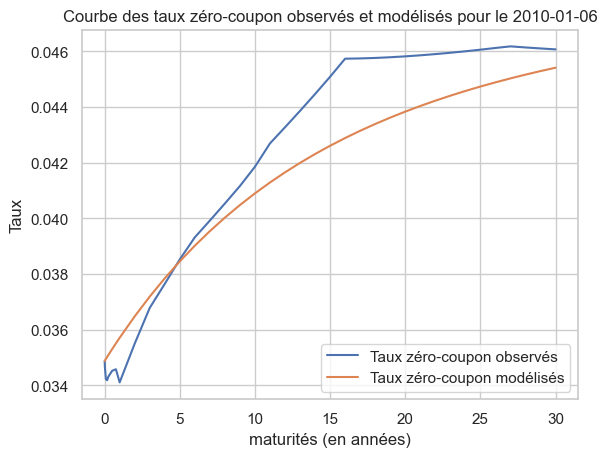

In [173]:
# a, b, sigma = 0.04413108, 0.0849325 , 0.01102  # VasiceK
dd_est = data_zc.copy() 

matrixx = []            

for row in dd_est.values:
    for i in range(1, len(row)):  # Commencer à partir de la deuxième colonne 
        T = maturities[i-1]       # Indexation de 0 pour la première colonne, donc i-1 pour maturities
        YY_YT = R(T, row[1], a, b, sigma)
        row[i] = YY_YT
    matrixx.append(list(row))
data_Modeled_CIR=pd.DataFrame(matrixx,columns=dd_est.columns)      
# Date spécifique pour laquelle tracer les courbes
date_specifique = "2010-01-06"
daf=df
donnees_modeled_specifique=data_Modeled_CIR[data_Modeled_CIR["Date de référence"]==date_specifique]
donnees_date_specifique = df[df["Date de référence"] == date_specifique]
taux_observés = donnees_date_specifique.iloc[0, 1:].values.astype(float)

taux_modélisés = donnees_modeled_specifique.iloc[0, 1:].values.astype(float)
# Tracer les courbes des taux zéro-coupon observés et modélisés
plt.plot(maturities, taux_observés, label='Taux zéro-coupon observés')
plt.plot(maturities, taux_modélisés, label='Taux zéro-coupon modélisés')
plt.xlabel('maturités (en années)')
plt.ylabel('Taux')
plt.title('Courbe des taux zéro-coupon observés et modélisés pour le ' + date_specifique)
plt.legend()
plt.grid(True)
plt.show()

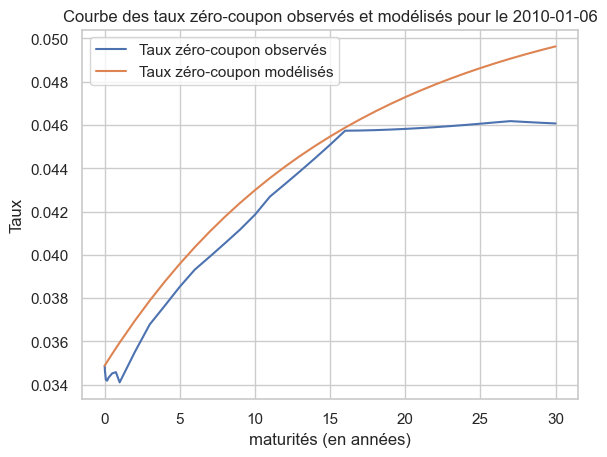

In [156]:
data=df.copy()
data.columns=['Date de référence']+ list(maturities)
# data.to_excel("donnees_modifiees.xlsx", index=False)
# data[data["Date de référence"]=="2023-03-03"]
# data.iloc[0]

In [ ]:
def find_nearest_date(date, data):
    nearest_date = data.iloc[(data['Date de référence'] - date).abs().idxmin()]
    return nearest_date.iloc[1:]

def Valorisation_BDT_Sim(tx, N, rt,d_val, d_ech):
        date_ver_c = []
        date_ver_c.append(d_ech)
        x = d_ech
        while x> d_val:
            date_ver_c.append(x)
            x = x - timedelta(days=365.25)
        date_ver_c.sort()
        mat = [(date - d_val).days / 365.25 for date in date_ver_c]
        valeur = 0
        def zc(t):
             return R_vasi(t,rt,a,b,sigma)
        for i in range(len(mat)):                    
            t=mat[i]    
            valeur += N * tx / (1 + zc(t)) ** (t)          
        valeur += N / (1 + zc(mat[-1])) ** mat[-1]
        return valeur

## 

def Valorisation_BDT(tx, N, r, d_val, d_ech):
        date_ver_c = []
        date_ver_c.append(d_ech)
        x = d_ech
        while x  > d_val:
            date_ver_c.append(x)
            x = x - timedelta(days=365.25)
        date_ver_c.sort()
        
        mat = [(date - d_val).days / 365.25 for date in date_ver_c]
        
        zc = interp1d(maturities,r,kind='linear',fill_value='extrapolate')
        valeur = 0
        for i in range(len(mat)):
            t=mat[i]
            # valeur += (N * tx / (1 + int_r(r,t) if t<30 else int_r(r,30) ) ** t)
            valeur += (N * tx / (1 + zc(t)) ** t)
            
        # valeur += N / (1 + int_r(r,mat[-1])) ** mat[-1]
        valeur += N / (1 + zc(mat[-1])) ** mat[-1]
        return valeur 
# d_val = datetime.strptime("04/03/2023", "%d/%m/%Y")
# d_ech = datetime.strptime("07/06/2026", "%d/%m/%Y")
# g=Valorisation_BDT( 0.062,210000000, data.iloc[0,1:], d_val, d_ech)                

In [157]:
data_Valorisation_Date=data_BDT.copy()
# Conversion des colonnes 'dt/val' et 'dt/ech' en objets datetime
data_Valorisation_Date['dt/val'] = data_Valorisation_Date['dt/val'].apply(lambda x: x.to_pydatetime())
data_Valorisation_Date['dt/ech'] = data_Valorisation_Date['dt/ech'].apply(lambda x: x.to_pydatetime())

In [ ]:

# def find_nearest_date(date, data):
#     nearest_date = data.iloc[(data['Date de référence'] - date).abs().idxmin()]
#     return nearest_date.iloc[1:]

# # j'ai ajouter cette ligne pour valoriser mon port au date au valeur
# data_Valorisation_Date['Valorisation_à_la_date_'+ str(Date_Valeur)]= data_Valorisation_Date.apply(lambda row: Valorisation_BDT(row['txno']/100, row['nominal'], find_nearest_date(Date_Valeur, data) , Date_Valeur, row['dt/ech']), axis=1)                                            
# for sem in range(104):
#     date=date - timedelta(days=7)                                        
#     data_Valorisation_Date['Valorisation_à_la_date_'+ str(date)]= data_Valorisation_Date.apply(lambda row: Valorisation_BDT(row['txno']/100, row['nominal'], find_nearest_date(date, data) , date, row['dt/ech']), axis=1)                                            

In [ ]:
Date_Valeur=datetime.strptime("2024-04-16", "%Y-%m-%d") # Date de Valorisation de notre portefeuil
date=Date_Valeur
date

In [ ]:
dates=df['Date de référence'].apply(lambda x: x.to_pydatetime())
dates

In [ ]:
date=dates[0]
date

In [ ]:
dates[3181]

In [ ]:
# Supposons que votre DataFrame s'appelle df et que la colonne des dates est "Date_col"
 
indice_date = df[df["Date de référence"] =="2010-01-06"].index[0]
indice_date


In [ ]:
while date >= dates[3218]:
    data_Valorisation_Date['Valorisation_à_la_date_'+ str(date)]= data_Valorisation_Date.apply(lambda row: Valorisation_BDT(row['txno']/100, row['nominal'], find_nearest_date(date, data) , date, row['dt/ech']), axis=1)  
    date = date - timedelta(days=1)
# for date in dates:
#     data_Valorisation_Date['Valorisation_à_la_date_'+ str(date)]= data_Valorisation_Date.apply(lambda row: Valorisation_BDT(row['txno']/100, row['nominal'], find_nearest_date(date, data_zc) , date, row['dt/ech']), axis=1)
                                            

In [ ]:
# exporter les données en format excel
data_Valorisation_Date.to_excel('Valorsiation du portefeuil.xlsx')

#### Calculon la VaR

##### Var Historique

In [158]:
# sommer par date de valeur pour obtenr la valeur du portefeuil pour chaque date
BDT_sum_Val_Port=data_Valorisation_Date.filter(regex='^Valorisation_à_la_date_').sum()
# BDT_sum_Val_Port.to_numpy()                                                            

In [ ]:
BDT_sum_Val_Port_df = pd.DataFrame({'Date_De_Valeur': BDT_sum_Val_Port.index, 'Valeur': BDT_sum_Val_Port.values})
# BDT_sum_Val_Port_df = pd.read_excel(r'C:\Users\hp\Desktop\Global folder for PFE\trainig intership\py\Calcul_VaR.xlsx', sheet_name='VaR Historique')
BDT_sum_Val_Port_df['P&L']= BDT_sum_Val_Port_df['Valeur'] - BDT_sum_Val_Port_df['Valeur'].shift(-1)
BDT_sum_Val_Port_df['Rendement']=np.log( BDT_sum_Val_Port_df['Valeur']/ BDT_sum_Val_Port_df['Valeur'].shift(-1))
# Afficher le DataFrame     
BDT_sum_Val_Port_df     

In [ ]:
BDT_sum_Val_Port_df['Date_De_Valeur'] = BDT_sum_Val_Port_df['Date_De_Valeur'].apply(
    lambda x: x.replace("Valorisation_à_la_date_", "").replace(" 00:00:00", "")
)

In [ ]:
BDT_sum_Val_Port_df

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Charger les données


dfd = BDT_sum_Val_Port_df.copy()
# dfd["Date_De_Valeur"] = pd.to_datetime(dfd["Date_De_Valeur"])

# Supprimer les lignes avec des valeurs manquantes
dfd.dropna(inplace=True)

# Test de Dickey-Fuller augmenté
result = adfuller(dfd["P&L"])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


In [ ]:
# VaR_Hist = BDT_sum_Val_Port_df['P&L'].quantile(0.01)  # Le quantile médian (50e percentile)
VaR_Hist = BDT_sum_Val_Port_df['Rendement'].quantile(0.01)*BDT_sum_Val_Port_df['Valeur'][0]
VaR_Hist

In [ ]:
# test_var(BDT_sum_Val_Port_df['P&L'], VaR_Hist, 0.01)

In [ ]:
# test_hypothesis_and_compute_statistic(BDT_sum_Val_Port_df['P&L'], x, 0.99, significance_level = 0.95)

In [ ]:
# test_var(BDT_sum_Val_Port_df['P&L'], VaR_MonteCa, 0.01)

In [ ]:
BDT_sum_Val_Port_df['P&L_exceeds_VaR'] = BDT_sum_Val_Port_df['P&L'] < VaR_Hist

# Compter combien de fois P&L dépasse VaR_Hist
count_exceeds = BDT_sum_Val_Port_df['P&L_exceeds_VaR'].sum()

# Calculer le pourcentage d'occurrences
total_count = len(BDT_sum_Val_Port_df)
percentage_exceeds = (count_exceeds / total_count) * 100

# Afficher le résultat
print(f"Le pourcentage de dépassement de P&L par rapport à VaR_Hist est de {percentage_exceeds:.2f}%")
exceeding_pnl_df = BDT_sum_Val_Port_df[BDT_sum_Val_Port_df['P&L'] < VaR_Hist]

# Afficher le DataFrame filtré
len(exceeding_pnl_df)


In [ ]:
BDT_sum_Val_Port_df.to_excel("Valorisation.xlsx")

##### VaR MonteCarlo

In [159]:
data_Simule=data_BDT.copy()

# a, b, sigma = 0.04413108, 0.0849325 , 0.01102

In [161]:
# Function to simulate interest rates using CIR model
dt=1/365
z_matrix=[]
def simulate_cir_vas(rt_prev, a, b, sigma, dt,horizone = 1): 
    rt = rt_prev #0jrs
    for _ in range(int(horizone)) : 
        dWt = np.random.normal(0, np.sqrt(dt))   
        rt = rt + a * (b - rt) * dt +np.sqrt(rt)*sigma * dWt 
    return rt # aprs h jours
# a, b, sigma= 0.028959627154054465, 0.13503538016652458, 0.01497951439088685
Date_Valeur = datetime.strptime("2024-04-16", "%Y-%m-%d")
date = Date_Valeur     
for scenario in range(6000):
    rt=simulate_cir_vas(0.031, a, b, sigma, dt,horizone=1)  # Initialize short rate for each scenario
    zc = [R(x, rt, a, b, sigma) for x in maturities]
    z_matrix.append(zc)
    data_Simule['Valorisation_scenario_' + str(scenario)] = data_Simule.apply(lambda row: Valorisation_BDT_Sim(row['txno']/100, row['nominal'], rt, date, row['dt/ech']), axis=1)

In [ ]:
data_Simule.columns[7:]

In [ ]:
Matrice_zc = pd.DataFrame(z_matrix, index=data_Simule.columns[7:].tolist(), columns=df.columns[1:].tolist())
# rename columns
Matrice_zc.rename(index=lambda x: x.replace("Valorisation_scenario_", "scenario_"), inplace=True)

In [162]:
# sommer par date de valeur pour obtenr la valeur du portefeuil pour chaque date
BDT_sum_Val_Port_Simule=data_Simule.filter(regex='^Valorisation_scenario_').sum()
BDT_sum_Val_Port_Simule_df = pd.DataFrame({'Date_De_Valeur': BDT_sum_Val_Port_Simule.index, 'Valeur': BDT_sum_Val_Port_Simule.values})
# BDT_sum_Val_Port_Simule_df=pd.read_excel(r'C:\Users\hp\Desktop\Global folder for PFE\trainig intership\py\Calcul_VaR.xlsx', sheet_name='VaR MonteCarlo')

In [163]:
BDT_sum_Val_Port_Simule_df

,Date_De_Valeur,Valeur
0,Valorisation_scenario_0,1.848220e+10
1,Valorisation_scenario_1,1.848479e+10
2,Valorisation_scenario_2,1.848660e+10
3,Valorisation_scenario_3,1.848533e+10
4,Valorisation_scenario_4,1.848762e+10
...,...,...
5995,Valorisation_scenario_5995,1.847270e+10
5996,Valorisation_scenario_5996,1.846584e+10
5997,Valorisation_scenario_5997,1.845826e+10
5998,Valorisation_scenario_5998,1.848526e+10


In [164]:
BDT_sum_Val_Port_Simule_df['P&L']= BDT_sum_Val_Port_Simule_df['Valeur'] - BDT_sum_Val_Port_df['Valeur'][0] 
BDT_sum_Val_Port_Simule_df['Rendement']= np.log(BDT_sum_Val_Port_Simule_df['Valeur']/ BDT_sum_Val_Port_df['Valeur'][0] )

# Afficher le DataFrame
VaR_MonteCa = BDT_sum_Val_Port_Simule_df['Rendement'].quantile(0.01)*BDT_sum_Val_Port_df['Valeur'][0]  # Le quantile 
VaR_MonteCa 

133853444.30012442

In [ ]:
Matrice_zc

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline

# Supposons que Matrice_zc soit déjà votre DataFrame

# Créer le graphique
sns.set(style="whitegrid")
plt.figure(figsize=(14, 10))

# Utiliser une palette de couleurs différentes pour chaque ligne
colors = sns.color_palette("husl", len(Matrice_zc.columns))

# Tracer chaque colonne (maturité)
for i, column in enumerate(Matrice_zc.columns):
    x = np.arange(len(Matrice_zc.index))  # Indices numériques pour l'axe x
    y = Matrice_zc[column]
    
    # Interpolation pour une courbe lisse
    x_smooth = np.linspace(x.min(), x.max(), 300)
    y_smooth = make_interp_spline(x, y)(x_smooth)
    
    plt.plot(x_smooth, y_smooth, color=colors[i], linewidth=2.5, label=column)
    # plt.scatter(x, y, color='black', s=50)  # Ajouter des points en noir pour les données réelles

# Ajouter le titre et les labels
plt.title("Évolution des taux d'intérêt simulés", fontsize=20)
plt.xlabel("Scénarios", fontsize=15)
plt.ylabel("Taux d'intérêt", fontsize=15)

# Ajouter une légende avec plus de personnalisation
plt.legend(title='Maturités', title_fontsize='13', fontsize='11', loc='upper left', bbox_to_anchor=(1, 1))

# Ajouter une grille
plt.grid(True)

# Afficher le graphique
plt.tight_layout()
plt.savefig("taux.pdf")
plt.show()


In [ ]:
with pd.ExcelWriter(r'C:\Users\hp\Desktop\Global folder for PFE\trainig intership\Calculation_VaR\data_exportes\Calcul_VaR.xlsx', engine='openpyxl') as writer:
    Matrice_zc.to_excel(writer, sheet_name='Taux simulées', index=True)

    BDT_sum_Val_Port_Simule_df.to_excel(writer, sheet_name='VaR MonteCarlo', index=False)

    BDT_sum_Val_Port_df.to_excel(writer, sheet_name='VaR Historique', index=False)

# ***************************************************************

Dans cette section On va utiliser la methode analytique pour calculer la VaR

### Test de la normalité

In [ ]:
dff=BDT_sum_Val_Port_df.copy()
plt.figure(figsize=(10, 6))
sns.histplot(dff['Rendement'], bins=50, kde=True, color='blue')
plt.title('Distribution des rendements')
plt.xlabel('Rendements')
plt.ylabel('Fréquence')
plt.grid(True)
plt.savefig("Normalite.pdf")
plt.show()

# 3. Tests de normalité
shapiro_test = stats.shapiro(dff['Rendement'])
print("Test de Shapiro-Wilk (H0: la distribution est normale) : p-value =", shapiro_test.pvalue)

# 4. Ajustement de distributions
# Vous pouvez essayer différentes distributions et ajuster leurs paramètres pour trouver la meilleure adéquation.


there is not enough evidence to reject normality. so we consider that dist is normal

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Exemple de données de rendements
rendements = np.random.normal(0, 0.01, 1000)  # Remplacez ceci par vos rendements réels

# Q-Q plot
plt.figure(figsize=(8, 6))
stats.probplot(rendements, dist="norm", plot=plt)
plt.title("Q-Q Plot des Rendements")
plt.xlabel("Quantiles Théoriques")
plt.ylabel("Quantiles des Données")
plt.grid(True)

# Enregistrer l'image
plt.savefig('qq_plot_rendements.png')
plt.show()


In [ ]:
plt.figure(figsize=(8, 6))
stats.probplot(dff['Rendement'], dist="norm", plot=plt)
plt.title('Q-Q plot des rendements')
plt.xlabel('Quantiles théoriques (distribution normale)')
plt.ylabel('Quantiles observés')
plt.grid(True)
plt.savefig("QQplot.pdf")
plt.show()

In [ ]:
dff=dff.dropna()

# 1. Test de distribution de Student (t-distribution)
student_params = stats.t.fit(dff['Rendement'])
student_dist = stats.t(*student_params)
student_test = stats.kstest(dff['Rendement'], student_dist.cdf)
print("Test de Kolmogorov-Smirnov (Student) : p-value =", student_test.pvalue)

# 2. Test de distribution du khi-deux (chi-squared)
chi2_params = stats.chi2.fit(dff['Rendement'])
chi2_dist = stats.chi2(*chi2_params)
chi2_test = stats.kstest(dff['Rendement'], chi2_dist.cdf)
print("Test de Kolmogorov-Smirnov (Chi-squared) : p-value =", chi2_test.pvalue)


On peut aajouter que notre distribution est normal

In [ ]:
dff=dff.dropna()

In [ ]:
from scipy.stats import jarque_bera

# Test de Jarque-Bera
jb_test_stat, jb_p_value = jarque_bera(dff['P&L'].dropna())

print("Statistique de test de Jarque-Bera :", jb_test_stat)
print("p-value :", jb_p_value)

# Interprétation du test
if jb_p_value < 0.05:
    print("Les données ne suivent pas une distribution normale (rejet de l'hypothèse nulle)")
else:
    print("Les données suivent une distribution normale (non-rejet de l'hypothèse nulle)")


On a effectué deux tests : le test de Jarque-Bera et le test de Shapiro. Alors que le test de Shapiro suggère que notre distribution est normale, le test de Jarque-Bera indique le contraire.

Supposons que notre distribution suive une loi normale. Dès lors, déterminons les paramètres de cette loi.

In [ ]:
# Calcul de la moyenne et de l'écart-type empiriques des rendements
mean_return = dff['Rendement'].mean()
std_return = dff['Rendement'].std()

print("Moyenne des rendements :", mean_return)
print("Écart-type des rendements :", std_return)


Pour déterminer la Value at Risk (VaR) au seuil de confiance de 99%, nous allon utiliser l'approche parametrique

Rappelons que la VaR représente la perte maximale attendue pour un niveau de confiance donné sur une certaine période. Pour une distribution normale, la VaR peut être calculée en utilisant la formule suivante :

$ \text{VaR}_{99\%} = \text{mean} + \text{std} \times \text{z-score}_{99\%} $

Où :
- mean est la moyenne des rendements,
- std est l'écart-type des rendements,
- z-score_{99%} est le z-score correspondant au niveau de confiance de 99%.

Le z-score associé à un niveau de confiance de 99% est généralement de 2.33 pour une distribution normale.

In [ ]:
# Calcul de la VaR au seuil de 99%
z_score_99 = 2.33  # Z-score pour un niveau de confiance de 99%
VaR_Anal =(std_return * z_score_99)*BDT_sum_Val_Port_df['Valeur'][0]
print("La VaR au seuil de 99% à l'horizon 1 jours est :", VaR_Anal )

Il y a une autre chose a montrer est que si la dist n'est pas normale on va utiliser le quantile corrigé $w_{\alpha}$ defini par la formule suivante:  
$$
\boxed{w_{\alpha}=z_{\alpha}+\frac{1}{6}(z_{\alpha}^{2}-1)S+\frac{1}{24}(z_{\alpha}^{3}-3z_{\alpha})K-\frac{1}{36}(2z_{\alpha}^{3}-5z_{\alpha})S^{2}}
$$

Le calcul de la Value-at-Risk se fait de manière similaire au calcul de la VaR dans le cas d’une loi 
normale. Il suffit alors de remplacer $z-score_{99\%}$ par $w_α$.

In [ ]:
dff=dff.dropna()
from scipy.stats import skew, kurtosis # type: ignore

# Calcul du coefficient de skewness
skewness = skew(dff['Rendement'])

# Calcul du coefficient de kurtosis
kurt = kurtosis(dff['Rendement'])

print("Coefficient de skewness (pour une distribution de la loi normale soit egal =0):", skewness)
print("Coefficient de kurtosis (pour une distribution de la loi normale soit egal =3):", kurt)  

In [ ]:
import numpy as np

def w_alpha(z_alpha, S, K):
    """
    Calcule w_alpha selon la formule donnée.
    
    Arguments:
    z_alpha -- quantile de la loi normale
    S -- asymétrie (skewness)
    K -- kurtosis (kurtosis)
    
    Retourne:
    w_alpha -- valeur calculée selon la formule
    """
    term1 = z_alpha
    term2 = (z_alpha**2 - 1) * S / 6
    term3 = (z_alpha**3 - 3 * z_alpha) * K / 24
    term4 = -(2 * z_alpha**3 - 5 * z_alpha) * S**2 / 36
    
    w_alpha = term1 + term2 + term3 + term4
    return w_alpha

# Exemple d'utilisation
z_alpha = 2.33  # Quantile pour un niveau de confiance de 99%
S = 0.1         # Exemple d'asymétrie
K = 3.0         # Exemple de kurtosis

w_alpha_value = w_alpha(z_alpha, S, K)
print(f"w_alpha = {w_alpha_value}")


In [ ]:
calculate_w(0.99, 2.33, 0.1, 3)

In [ ]:
def calculate_w(alpha, z_alpha, S, K):
    w_alpha = z_alpha + (1/6) * (z_alpha**2 - 1) * S + (1/24) * (z_alpha**3 - 3*z_alpha) * K - (1/36) * (2*z_alpha**3 - 5*z_alpha) * S**2
    return w_alpha

# Exemple d'utilisation avec des valeurs arbitraires pour alpha, z_alpha, S et K 
alpha = 0.99                                                 
z_alpha = 2.33  # Z-score pour un niveau de confiance de 99%
S = skewness  # Coefficient de skewness de vos données
K = kurt  # Coefficient de kurtosis de vos données

w_alpha = calculate_w(alpha, z_alpha, S, K)               
print("w_alpha :", w_alpha)

In [ ]:
# Calcul de la VaR dans le cas où la distribution non normale                                
VaR_99 = mean_return + std_return * w_alpha                                
print("La VaR au seuil de 99% est :", VaR_99)                                
print("La VaR au seuil de 99% à l'horizon 1 jours est :",VaR_99*18_329_481_999.0639 )                                

La VaR au seuil de 99% est : 0.012370793159665617
La VaR au seuil de 99% à l'horizon 1 jours est : 0.004675720317299167

Dans ce cas on va utiliser la distribution de student

-- VaR_Monte Carlo(vaR1) == 17210565.9239455

-- VaR_Historique(VaR2) == 94496602.54789686

-- VaR_Anlytique(VaR3) == 0.004675720317299167\*17679101586= 82662534.47725613 (Normal) 0.010686572402988058\*17679101586 188928999.11857(Student)


$$
\text{{VaR\_Anlytique(VaR3)}} = \left\{
\begin{array}{ll}
82662534.47725613 & \text{{(Normal)}} \\
188928999.11857 & \text{{(Student)}}
\end{array}
\right.
$$


In [ ]:


# Supposons que vous ayez une liste de dates correspondant aux valeurs du portefeuille
# Assurez-vous de remplacer [...] par vos propres dates

# Supposons que vous ayez une liste de valeurs de portefeuille par date
portefeuille_valeurs = ddf['P&L']  # Assurez-vous de remplacer [...] par vos propres valeurs de portefeuille
dates=ddf['Date_De_Valeur']
# Supposons que vous ayez une valeur fixe pour la VaR
# VaR = 82662534.47725613  # Normal VaR
# VaR= -188928999.11857  # Student
# VaR = 94496602.54789686 # Historique
VaR = 1527742059.542604 #Monte Carlo
# Plot des valeurs de portefeuille
plt.plot(dates, portefeuille_valeurs, label='Portefeuille')

# Plot de la VaR (une droite horizontale)
plt.axhline(y=VaR, color='r', linestyle='--', label='VaR')

# Ajout de légendes et de titres
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.title('Evolution du Portefeuille et VaR')
plt.legend()

# Affichage du graphique
plt.show()

## using maximum likelihood

Le modèle de CIR est le suivant: 
$$
dr_t = α(µ − rt)dt + \sqrt {r_t} \sigma dW_t

$$

\begin{equation}
p(r_{t+\Delta t} | r_t; \theta, \Delta t) = c e^{-u-v} \left( \frac{v}{u} \right)^{ \frac{q}{2}} I_q(2\sqrt{uv}),
\end{equation}

where
\begin{align*}
c &= \frac{2\alpha}{\sigma^2 (1 - e^{-\alpha \Delta t})}, \\
u &= cr_te^{-\alpha \Delta t}, \\
v &= cr_{t+\Delta t}, \\
q &= \frac{2\alpha\mu}{\sigma^2} - 1,
\end{align*}

and $I_q(2\sqrt{uv})$ is the modified Bessel function of the first kind and of order $q$.


# *******************************

In [ ]:
rt=df_c['1 J']
rt

#*************************************

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.special import iv  # Modified Bessel function of the first kind

# # Supposons que rt soit la série temporelle des taux d'intérêt
rt = df_c['1 J'].values


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.special import iv  # Modified Bessel function of the first kind

# # Supposons que rt soit la série temporelle des taux d'intérêt
rt = df_c['1 J'].values

N = len(rt)        
delta_t = 1 # Intervalle de temps (par exemple, 1 jour)        

# Fonction pour calculer les estimations initiales d'alpha et mu        
def initial_estimates(rt, delta_t):
    y = (rt[1:] - rt[:-1]) / np.sqrt(rt[:-1])
    X = np.vstack([1/np.sqrt(rt[:-1]), np.sqrt(rt[:-1]) * delta_t]).T
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    alpha = -beta[1] / delta_t
    mu = beta[0] / (beta[1] * delta_t)
    return alpha, mu

# Estimation initiale de sigma
def estimate_sigma(rt, alpha, mu, delta_t):
    residuals = (rt[1:] - rt[:-1] - alpha * (mu - rt[:-1]) * delta_t) / np.sqrt(rt[:-1])
    sigma = np.std(residuals)
    return sigma

# Fonction de log-vraisemblance
def log_likelihood(theta, rt, delta_t):
    alpha, mu, sigma = theta
    N = len(rt)
    c = 2 * alpha / (sigma**2 * (1 - np.exp(-alpha * delta_t)))
    q = 2 * alpha * mu / sigma**2 - 1
    
    log_lik = 0
    for i in range(N - 1):
        u = c * rt[i] * np.exp(-alpha * delta_t)
        v = c * rt[i+1]
        log_lik += (np.log(c) - u - v + 0.5 * q * np.log(v/u) + np.log(iv(q, 2 * np.sqrt(u * v))))
    return -log_lik

# Calculer les estimations initiales
# alpha_init, mu_init = 0.1, 0.05
# sigma_init = 0.02
alpha_init, mu_init=initial_estimates(rt, delta_t)

alpha_init, mu_init = 0.1137805121585627, 0.04311965977532673
sigma_init = 0.019999641509027735

# Estimations initiales
theta_init = [alpha_init, mu_init, sigma_init]

# Maximiser la log-vraisemblance
result = minimize(log_likelihood, theta_init, args=(rt, delta_t), bounds=((0, None), (0, None), (0, None)), method="L-BFGS-B")

# Estimations finales
alpha_est, mu_est, sigma_est = result.x

print(f"Estimation de alpha: {alpha_est}")
print(f"Estimation de mu: {mu_est}")
print(f"Estimation de sigma: {sigma_est}")

In [ ]:
import numpy as np
import pandas as pd

# Supposons que rt soit la série temporelle des taux d'intérêt
rt = df_c['1 J'].values

N = len(rt)
delta_t = 1  # Intervalle de temps (par exemple, 1 jour)

# Calculer les sommes nécessaires
sum_rt = np.sum(rt[:-1])
sum_rt_next = np.sum(rt[1:])
sum_1_rt = np.sum(1 / rt[:-1])
sum_rt_rt_next = np.sum(rt[1:] / rt[:-1])
sum_rt_1_rt = np.sum(rt[:-1] / rt[:-1])

# Calculer alpha
numerator_alpha = N**2 - 2*N + 1 + sum_rt_next * sum_1_rt - sum_rt * sum_1_rt - (N - 1) * sum_rt_rt_next
denominator_alpha = (N**2 - 2*N + 1 - sum_rt * sum_1_rt) * delta_t

alpha = numerator_alpha / denominator_alpha

# Calculer mu

numerator_mu = (N - 1) * sum_rt_next - sum_rt_rt_next * sum_rt 
denominator_mu = N**2 - 2*N + 1 + sum_rt_next * sum_1_rt - sum_rt * sum_1_rt - (N - 1) * sum_rt_rt_next

mu = numerator_mu / denominator_mu

print(f"Estimation de alpha: {alpha}")
print(f"Estimation de mu: {mu}")


In [ ]:
residuals = (rt[1:] - rt[:-1] - alpha * (mu - rt[:-1]) * delta_t) / np.sqrt(rt[:-1])

# Estimer sigma
sigma = np.std(residuals)
print(f"Estimation de sigma: {sigma}")

In [ ]:

# Charger les données
data = pd.read_excel('data.xlsx')

# Convertir les dates en datetime
data['Date de référence'] = pd.to_datetime(data['Date de référence'])

# Trier les données par date
data = data.sort_values(by='Date de référence')

# Calculer les rendements log
data['1J_log_return'] = np.log(data['1 J'] / data['1 J'].shift(1))

# Retirer les NaN résultants du décalage
data = data.dropna()

# Afficher les premières lignes des données avec les rendements
data.head()


In [ ]:
from scipy.optimize import minimize

# Fonction pour calculer la vraisemblance négative du modèle CIR
def neg_log_likelihood(params, returns):
    a, b, sigma = params
    n = len(returns)
    likelihood = -np.sum(-0.5 * (returns**2) / (sigma**2 * returns) - 0.5 * np.log(2 * np.pi * sigma**2 * returns))
    return -likelihood

# Initialiser les paramètres
initial_params = [0.1, 0.05, 0.02]

# Effectuer l'optimisation pour trouver les meilleurs paramètres
result = minimize(neg_log_likelihood, initial_params, args=(data['1J_log_return'],), method='L-BFGS-B', bounds=[(0, None), (0, None), (0, None)])

# Extraire les paramètres optimisés
a_opt, b_opt, sigma_opt = result.x

print(f"Paramètres optimisés du modèle CIR:\na = {a_opt}\nb = {b_opt}\nsigma = {sigma_opt}")

# Visualisation

### Visaulisation des courbes

In [ ]:
def plot_curves(date_specifique):
    donnees_date_specifique = df[df["Date de référence"] == date_specifique]
    donnees_modeled_specifique = data_Modeled_CIR[data_Modeled_CIR["Date de référence"] == date_specifique]
    
    if donnees_date_specifique.empty or donnees_modeled_specifique.empty:
        print(f"Aucune donnée trouvée pour la date {date_specifique}.")
        return
    
    taux_observés = donnees_date_specifique.iloc[0, 1:].values.astype(float)
    taux_modélisés = donnees_modeled_specifique.iloc[0, 1:].values.astype(float)
    
    # Tracer les courbes des taux zéro-coupon observés et modélisés
    plt.figure(figsize=(10, 6))
    plt.plot(maturities, taux_observés, label='Taux zéro-coupon observés', marker='o')
    plt.plot(maturities, taux_modélisés, label='Taux zéro-coupon modélisés', marker='x')
    plt.xlabel('Maturités (en années)')
    plt.ylabel('Taux')
    plt.title(f'Courbe des taux zéro-coupon observés et modélisés pour le {date_specifique}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.savefig('courbe.pdf')
    plt.show()

In [ ]:
# date=df['Date de référence'][6]
date="2024-04-01"
plot_curves(date)




In [ ]:
VaR_Anal

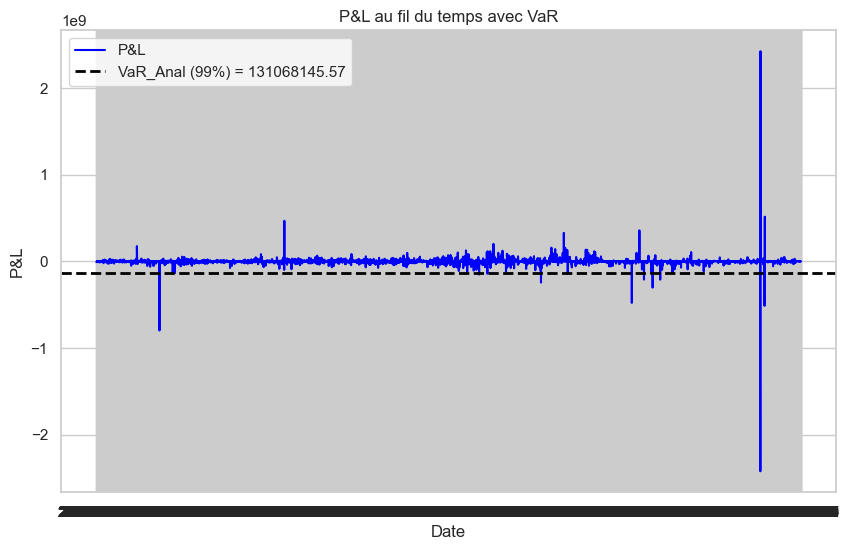

In [153]:
def Plot_Value_At_Risk(VaR_MonteCa,VaR_Hist, VaR_Anal):
    plt.figure(figsize=(10, 6))
    plt.plot(BDT_sum_Val_Port_df['Date_De_Valeur'], BDT_sum_Val_Port_df['P&L'], label='P&L', color='blue')

    # Ajouter une ligne horizontale pour la VaR
    # plt.axhline(y=VaR_Hist, color='red', linestyle='--', linewidth=2, label=f'VaR_Hist (99%) = {-VaR_Hist:.2f}')
    # plt.axhline(y=VaR_MonteCa, color='green', linestyle='--', linewidth=2, label=f'VaR_Mont (99%) = {-VaR_MonteCa:.2f}')
    plt.axhline(y=-VaR_Anal, color='black', linestyle='--', linewidth=2, label=f'VaR_Anal (99%) = {VaR_Anal:.2f}')

    # Ajouter des étiquettes et un titre
    plt.title('P&L au fil du temps avec VaR')
    plt.xlabel('Date')
    plt.ylabel('P&L')
    plt.legend()
    # Afficher la figure
    plt.savefig("VaR_Hist.pdf")
    plt.show()
Plot_Value_At_Risk(VaR_MonteCa,VaR_Hist, VaR_Anal)

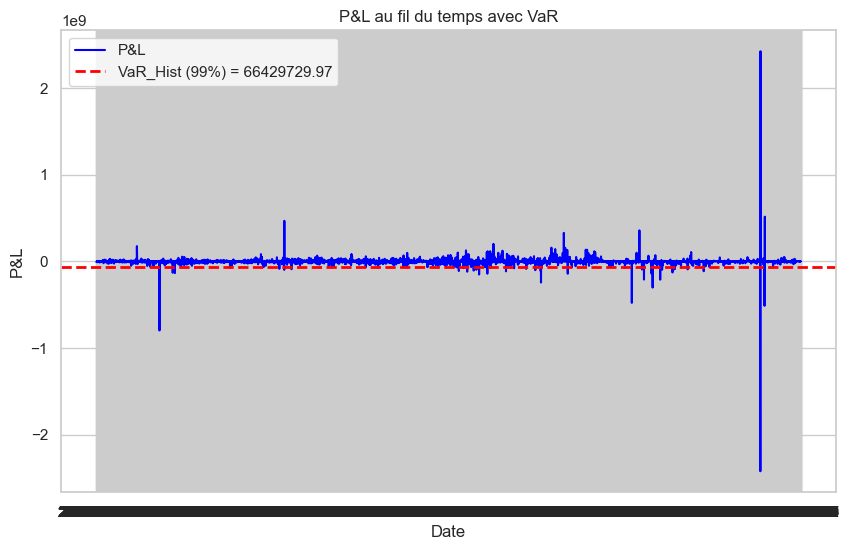

In [150]:
def Plot_Value_At_Risk(VaR_MonteCa,VaR_Hist, VaR_Anal):
    plt.figure(figsize=(10, 6))
    plt.plot(BDT_sum_Val_Port_df['Date_De_Valeur'], BDT_sum_Val_Port_df['P&L'], label='P&L', color='blue')

    # Ajouter une ligne horizontale pour la VaR
    plt.axhline(y=VaR_Hist, color='red', linestyle='--', linewidth=2, label=f'VaR_Hist (99%) = {-VaR_Hist:.2f}')
    # plt.axhline(y=VaR_MonteCa, color='green', linestyle='--', linewidth=2, label=f'VaR_Mont (99%) = {-VaR_MonteCa:.2f}')
    # plt.axhline(y=-VaR_Anal, color='black', linestyle='--', linewidth=2, label=f'VaR_Anal (99%) = {VaR_Anal:.2f}')

    # Ajouter des étiquettes et un titre
    plt.title('P&L au fil du temps avec VaR')
    plt.xlabel('Date')
    plt.ylabel('P&L')
    plt.legend()
    # Afficher la figure
    plt.savefig("VaR_Hist.pdf")
    plt.show()
Plot_Value_At_Risk(VaR_MonteCa,VaR_Hist, VaR_Anal)

In [148]:
import numpy as np
import pandas as pd
from scipy.stats import chi2

dff
VaR = VaR_Anal

# Calcul des exceptions
dff['Exception'] = dff['P&L'] >VaR
num_exceptions = dff['Exception'].sum()

# Parametres pour le test Kupiec POF
T = len(dff)  # Nombre total d'observations
p = 0.01  # Taux de defaillance attendu (pour une VaR au niveau de confiance de 99%, p = 1 - 0.99)

# Statistique du test Kupiec POF
LR_pof = -2 * np.log(((1 - p)**(T - num_exceptions) * p**num_exceptions) / 
                     ((1 - num_exceptions/T)**(T - num_exceptions) * (num_exceptions/T)**num_exceptions))

# Valeur p pour la statistique du test
p_value = chi2.sf(LR_pof, 1)

print(f"Nombre d'exceptions : {num_exceptions}")
print(f"Statistique du test Kupiec POF : {LR_pof}")
print(f"Valeur p : {p_value}")


Nombre d'exceptions : 13
Statistique du test Kupiec POF : 42.462473927646215
Valeur p : 7.205142601997121e-11


In [145]:
VaR_Anal

131068145.57452524